In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()  
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
setup_google_colab.setup_project()
# setup_google_colab.setup_honor()

--2020-05-15 12:24:02--  https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1991 (1.9K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.94K  --.-KB/s    in 0s      

2020-05-15 12:24:03 (20.0 MB/s) - ‘setup_google_colab.py’ saved [1991/1991]



# Final project: StackOverflow assistant bot

Congratulations on coming this far and solving the programming assignments! In this final project, we will combine everything we have learned about Natural Language Processing to construct a *dialogue chat bot*, which will be able to:
* answer programming-related questions (using StackOverflow dataset);
* chit-chat and simulate dialogue on all non programming-related questions.

For a chit-chat mode we will use a pre-trained neural network engine available from [ChatterBot](https://github.com/gunthercox/ChatterBot).
Those who aim at honor certificates for our course or are just curious, will train their own models for chit-chat.
![](https://imgs.xkcd.com/comics/twitter_bot.png)
©[xkcd](https://xkcd.com)

### Data description

To detect *intent* of users questions we will need two text collections:
- `tagged_posts.tsv` — StackOverflow posts, tagged with one programming language (*positive samples*).
- `dialogues.tsv` — dialogue phrases from movie subtitles (*negative samples*).


In [0]:
import sys
sys.path.append("..")
from common.download_utils import download_project_resources

download_project_resources()

File data/dialogues.tsv is already downloaded.
File data/tagged_posts.tsv is already downloaded.


For those questions, that have programming-related intent, we will proceed as follow predict programming language (only one tag per question allowed here) and rank candidates within the tag using embeddings.
For the ranking part, you will need:
- `word_embeddings.tsv` — word embeddings, that you  trained with StarSpace in the 3rd assignment. It's not a problem if you didn't do it, because we can offer an alternative solution for you.

As a result of this notebook, you should obtain the following new objects that you will then use in the running bot:

- `intent_recognizer.pkl` — intent recognition model;
- `tag_classifier.pkl` — programming language classification model;
- `tfidf_vectorizer.pkl` — vectorizer used during training;
- `thread_embeddings_by_tags` — folder with thread embeddings, arranged by tags.
    

Some functions will be reused by this notebook and the scripts, so we put them into *utils.py* file. Don't forget to open it and fill in the gaps!

In [0]:
from utils import *

## Part I. Intent and language recognition

We want to write a bot, which will not only **answer programming-related questions**, but also will be able to **maintain a dialogue**. We would also like to detect the *intent* of the user from the question (we could have had a 'Question answering mode' check-box in the bot, but it wouldn't fun at all, would it?). So the first thing we need to do is to **distinguish programming-related questions from general ones**.

It would also be good to predict which programming language a particular question referees to. By doing so, we will speed up question search by a factor of the number of languages (10 here), and exercise our *text classification* skill a bit. :)

In [0]:
import numpy as np
import pandas as pd
import pickle
import re

from sklearn.feature_extraction.text import TfidfVectorizer

### Data preparation

In the first assignment (Predict tags on StackOverflow with linear models), you have already learnt how to preprocess texts and do TF-IDF tranformations. Reuse your code here. In addition, you will also need to [dump](https://docs.python.org/3/library/pickle.html#pickle.dump) the TF-IDF vectorizer with pickle to use it later in the running bot.

In [0]:
def tfidf_features(X_train, X_test, vectorizer_path):
    """Performs TF-IDF transformation and dumps the model."""
    
    # Train a vectorizer on X_train data.
    # Transform X_train and X_test data.
    
    # Pickle the trained vectorizer to 'vectorizer_path'
    # Don't forget to open the file in writing bytes mode.
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################

    tfidf_vectorizer = TfidfVectorizer(token_pattern='(\S+)', ngram_range=(1, 2), max_df=0.9, min_df=5)
    tfidf_vectorizer.fit(X_train)
    X_train, X_test = (tfidf_vectorizer.transform(X) for X in [X_train, X_test])

    pickle_out = open(vectorizer_path,"wb")
    pickle.dump(tfidf_vectorizer, pickle_out)
    pickle_out.close()
    
    return X_train, X_test

Now, load examples of two classes. Use a subsample of stackoverflow data to balance the classes. You will need the full data later.

In [0]:
sample_size = 200000

dialogue_df = pd.read_csv('data/dialogues.tsv', sep='\t').sample(sample_size, random_state=0)
stackoverflow_df = pd.read_csv('data/tagged_posts.tsv', sep='\t').sample(sample_size, random_state=0)

Check how the data look like:

In [0]:
dialogue_df.head()

,text,tag
82925,"Donna, you are a muffin.",dialogue
48774,He was here last night till about two o'clock....,dialogue
55394,"All right, then make an appointment with her s...",dialogue
90806,"Hey, what is this-an interview? We're supposed...",dialogue
107758,Yeah. He's just a friend of mine I was trying ...,dialogue


In [0]:
stackoverflow_df.head()

,post_id,title,tag
2168983,43837842,Efficient Algorithm to compose valid expressio...,python
1084095,15747223,Why does this basic thread program fail with C...,c_cpp
1049020,15189594,Link to scroll to top not working,javascript
200466,3273927,Is it possible to implement ping on windows ph...,c#
1200249,17684551,GLSL normal mapping issue,c_cpp


Apply *text_prepare* function to preprocess the data:

In [0]:
from utils import text_prepare

In [0]:
dialogue_df['text'] = dialogue_df['text'].map(lambda text: text_prepare(text))######### YOUR CODE HERE #############
stackoverflow_df['title'] = stackoverflow_df['title'].map(lambda title: text_prepare(str(title)))######### YOUR CODE HERE #############

### Intent recognition

In [0]:
dialogue_df.head()

,text,tag
82925,donna muffin,dialogue
48774,last night till two oclock hear really got stu...,dialogue
55394,right make appointment see,dialogue
90806,hey thisan interview supposed making love,dialogue
107758,yeah hes friend mine trying help,dialogue


In [0]:
stackoverflow_df.head()

,post_id,title,tag
2168983,43837842,efficient algorithm compose valid expressions ...,python
1084095,15747223,basic thread program fail clang pass g++,c_cpp
1049020,15189594,link scroll top working,javascript
200466,3273927,possible implement ping windows phone 7,c#
1200249,17684551,glsl normal mapping issue,c_cpp


We will do a binary classification on TF-IDF representations of texts. Labels will be either `dialogue` for general questions or `stackoverflow` for programming-related questions. First, prepare the data for this task:
- concatenate `dialogue` and `stackoverflow` examples into one sample
- split it into train and test in proportion 9:1, use *random_state=0* for reproducibility
- transform it into TF-IDF features

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X = np.concatenate([dialogue_df['text'].values, stackoverflow_df['title'].values])
y = ['dialogue'] * dialogue_df.shape[0] + ['stackoverflow'] * stackoverflow_df.shape[0]

In [0]:
RESOURCE_PATH

{'INTENT_RECOGNIZER': 'intent_recognizer.pkl',
 'TAG_CLASSIFIER': 'tag_classifier.pkl',
 'TFIDF_VECTORIZER': 'tfidf_vectorizer.pkl',
 'THREAD_EMBEDDINGS_FOLDER': 'thread_embeddings_by_tags',
 'WORD_EMBEDDINGS': 'word_embeddings.tsv'}

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 0)
print('Train size = {}, test size = {}'.format(len(X_train), len(X_test)))
#VECTORIZER_PATH = "data/tfidf_trained.pkl"
X_train_tfidf, X_test_tfidf = tfidf_features(X_train, X_test, RESOURCE_PATH['TFIDF_VECTORIZER']) ######### YOUR CODE HERE ###########

Train size = 360000, test size = 40000


Train the **intent recognizer** using LogisticRegression on the train set with the following parameters: *penalty='l2'*, *C=10*, *random_state=0*. Print out the accuracy on the test set to check whether everything looks good.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [0]:
######################################
######### YOUR CODE HERE #############
######################################
intent_recognizer = LogisticRegression(penalty='l2', tol=0.0001, C=10.0, max_iter=1000, random_state=0)
intent_recognizer.fit(X_train_tfidf, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Check test accuracy.
y_test_pred = intent_recognizer.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy = {}'.format(test_accuracy))

Test accuracy = 0.991575


Dump the classifier to use it in the running bot.

In [0]:
pickle.dump(intent_recognizer, open(RESOURCE_PATH['INTENT_RECOGNIZER'], 'wb'))

### Programming language classification 

We will train one more classifier for the programming-related questions. It will predict exactly one tag (=programming language) and will be also based on Logistic Regression with TF-IDF features. 

First, let us prepare the data for this task.

In [0]:
X = stackoverflow_df['title'].values
y = stackoverflow_df['tag'].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('Train size = {}, test size = {}'.format(len(X_train), len(X_test)))

Train size = 160000, test size = 40000


Let us reuse the TF-IDF vectorizer that we have already created above. It should not make a huge difference which data was used to train it.

In [0]:
vectorizer = pickle.load(open(RESOURCE_PATH['TFIDF_VECTORIZER'], 'rb'))

X_train_tfidf, X_test_tfidf = vectorizer.transform(X_train), vectorizer.transform(X_test)

Train the **tag classifier** using OneVsRestClassifier wrapper over LogisticRegression. Use the following parameters: *penalty='l2'*, *C=5*, *random_state=0*.

In [0]:
from sklearn.multiclass import OneVsRestClassifier

In [0]:
######################################
######### YOUR CODE HERE #############
######################################

tag_classifier = OneVsRestClassifier(LogisticRegression(penalty='l2', tol=0.0001, C=10.0, max_iter=1000, random_state=0))
tag_classifier.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=10.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=0, solver='lbfgs',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False),
                    n_jobs=None)

In [0]:
# Check test accuracy.
y_test_pred = tag_classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy = {}'.format(test_accuracy))

Test accuracy = 0.7959


Dump the classifier to use it in the running bot.

In [0]:
pickle.dump(tag_classifier, open(RESOURCE_PATH['TAG_CLASSIFIER'], 'wb'))

## Part II. Ranking  questions with embeddings

To find a relevant answer (a thread from StackOverflow) on a question you will use vector representations to calculate similarity between the question and existing threads. We already had `question_to_vec` function from the assignment 3, which can create such a representation based on word vectors. 

However, it would be costly to compute such a representation for all possible answers in *online mode* of the bot (e.g. when bot is running and answering questions from many users). This is the reason why you will create a *database* with pre-computed representations. These representations will be arranged by non-overlaping tags (programming languages), so that the search of the answer can be performed only within one tag each time. This will make our bot even more efficient and allow not to store all the database in RAM. 

Load StarSpace embeddings which were trained on Stack Overflow posts. These embeddings were trained in *supervised mode* for duplicates detection on the same corpus that is used in search. We can account on that these representations will allow us to find closely related answers for a question. 

If for some reasons you didn't train StarSpace embeddings in the assignment 3, you can use [pre-trained word vectors](https://code.google.com/archive/p/word2vec/) from Google. All instructions about how to work with these vectors were provided in the same assignment. However, we highly recommend to use StarSpace's embeddings, because it contains more appropriate embeddings. If you chose to use Google's embeddings, delete the words, which is not in Stackoverflow data.

In [0]:
!wget https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1

--2020-05-15 13:00:55--  https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1453905423 (1.4G) [application/octet-stream]
Saving to: ‘SO_vectors_200.bin?download=1’

SO_vectors_200.bin? 100%[===================>]   1.35G  15.6MB/s    in 93s     

2020-05-15 13:02:29 (14.9 MB/s) - ‘SO_vectors_200.bin?download=1’ saved [1453905423/1453905423]



In [0]:
import gensim
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
starspace_embeddings = KeyedVectors.load_word2vec_format("SO_vectors_200.bin?download=1", binary=True)
embeddings_dim = 200

In [0]:
#starspace_embeddings, embeddings_dim = load_embeddings('data/word_embeddings.tsv')

Since we want to precompute representations for all possible answers, we need to load the whole posts dataset, unlike we did for the intent classifier:

In [0]:
posts_df = pd.read_csv('data/tagged_posts.tsv', sep='\t')

In [0]:
posts_df.head()

,post_id,title,tag
0,9,Calculate age in C#,c#
1,16,Filling a DataSet or DataTable from a LINQ que...,c#
2,39,Reliable timer in a console application,c#
3,42,Best way to allow plugins for a PHP application,php
4,59,"How do I get a distinct, ordered list of names...",c#


Look at the distribution of posts for programming languages (tags) and find the most common ones. 
You might want to use pandas [groupby](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) and [count](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.count.html) methods:

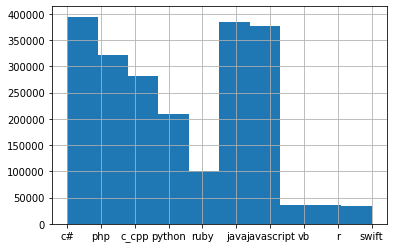

In [0]:
hist = posts_df["tag"].hist()

In [0]:
counts_by_tag = posts_df.filter(items=['post_id', 'tag']).groupby(['tag']).count().to_dict()['post_id'] ######### YOUR CODE HERE #############
counts_by_tag


{'c#': 394451,
 'c_cpp': 281300,
 'java': 383456,
 'javascript': 375867,
 'php': 321752,
 'python': 208607,
 'r': 36359,
 'ruby': 99930,
 'swift': 34809,
 'vb': 35044}

Now for each `tag` you need to create two data structures, which will serve as online search index:
* `tag_post_ids` — a list of post_ids with shape `(counts_by_tag[tag],)`. It will be needed to show the title and link to the thread;
* `tag_vectors` — a matrix with shape `(counts_by_tag[tag], embeddings_dim)` where embeddings for each answer are stored.

Implement the code which will calculate the mentioned structures and dump it to files. It should take several minutes to compute it.

In [0]:
posts_df2 = posts_df[:5]
tag_posts = posts_df2[posts_df2['tag'] == 'c#']
print(tag_posts['post_id'].to_list())

[9, 16, 39, 59]


In [0]:
def question_to_vec(question, embeddings, dim=200):
    """
        question: a string
        embeddings: dict where the key is a word and a value is its' embedding
        dim: size of the representation

        result: vector representation for the question
    """
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    result = np.zeros((dim,))
    ques = question.split()
    n = 0
    #print("result", result.shape)
    for word in ques:
      if word in embeddings.vocab:
        #print("embed", embeddings[word].shape)
        result += embeddings[word]
        n += 1

    if n > 0:
      result = result / n

    return result

In [0]:
import os
os.makedirs(RESOURCE_PATH['THREAD_EMBEDDINGS_FOLDER'], exist_ok=True)

for tag, count in counts_by_tag.items():
    tag_posts = posts_df[posts_df['tag'] == tag]
    
    tag_post_ids = tag_posts['post_id'].to_list() ######### YOUR CODE HERE #############
    
    tag_vectors = np.zeros((count, embeddings_dim), dtype=np.float32)
    for i, title in enumerate(tag_posts['title']):
        tag_vectors[i, :] = question_to_vec(title, starspace_embeddings, embeddings_dim)######### YOUR CODE HERE #############

    # Dump post ids and vectors to a file.
    filename = os.path.join(RESOURCE_PATH['THREAD_EMBEDDINGS_FOLDER'], os.path.normpath('%s.pkl' % tag))
    pickle.dump((tag_post_ids, tag_vectors), open(filename, 'wb'))